In [1]:
import pandas as pd
import numpy as np
import random
import pickle as pkl
from tqdm import tqdm 
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import random
import string

# 0. Before starting

The first thing to do is to open the dataset and check if there are some midifications to apply.

In [27]:
data = pd.read_csv('./bank_transactions.csv', sep=',')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


We can notice that there are some values that are missing, so we have to deal with them.

In [28]:
data.dropna(inplace=True)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


Another thing that we notice is that there are some inconsistencies with the 'CustomerDOB' column. To show it we will convert the DOB to a datetime variable and plot the histogram.

<AxesSubplot:>

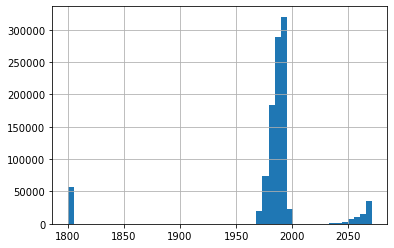

In [46]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.CustomerDOB.dt.year.hist(bins=50)

From the histogram we can see that there are some people that seems to be born in 1800 and others not born yet.

To fix this we will delete from the dataset the people born in 1800 and bring back of 100 years the one in the future.

In [47]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

We can now take a look at the new histogram.

<AxesSubplot:>

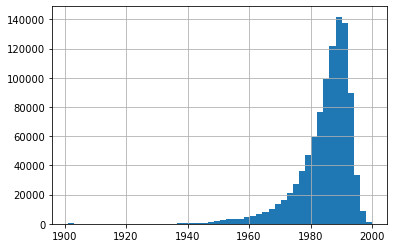

In [48]:
data.CustomerDOB.dt.year.hist(bins=50)

Now that we dealt with the biggest problems of the dataset we can start to work on it.

# 1 Finding Similar Costumers

## 1.1 Set up the data

Our first goal is to build a algorithm that will help us recognize similar people. To do that we decided to base our research only on some of the columns, so we can get rid of the ones we are not going to use.

In [49]:
del data['TransactionID']
del data['TransactionTime']
del data['TransactionDate']

Also there are some columns that we do want to use, but not how they are:
- DOB, we are only intrested on the age of each costumer and not the exact data of birth.
- CustomerID, we also noticed that there are some problems with the CustomerID. It looks like there are some CustomerId that have different date of birth or gendere, so we decided to build a new ID by putting together the CustomereID + DOB.

In [50]:
data['CustAge'] = data['CustomerDOB'].apply(lambda x: str(date.today().year - x.year - ((date.today().month ,date.today().day)<(x.month, x.day))))

In [51]:
data['MyID'] = data['CustomerID']+' '+ data['CustomerDOB'].apply(lambda x: str(x.year)+'-'+str(x.month)+'-'+str(x.day))

In [52]:
# Now we don't need this columns anymore and we can drop them
del data['CustomerID']
del data['CustomerDOB']

Let's see what we are left with:

In [53]:
data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustAge,MyID
0,F,JAMSHEDPUR,17819.05,25.0,28,C5841053 1994-10-1
1,M,JHAJJAR,2270.69,27999.0,65,C2142763 1957-4-4
2,F,MUMBAI,17874.44,459.0,26,C4417068 1996-11-26
3,F,MUMBAI,866503.21,2060.0,49,C5342380 1973-9-14
4,F,NAVI MUMBAI,6714.43,1762.5,34,C9031234 1988-3-24


Now it's time to work on the $CustAccountBalance$ and $TransactionAmount (INR)$, since there are so many different possible values in those columns we will devide them in ranges using the quantiles.

In [54]:
# Function that given x and a list of touples that rapresent some intervals will return the touple with the values of the interval that contains x
def find_range(x, Range):
    for range in Range:
        if x>=range[0] and x<range[1]:
            return range
    return Range[-1]

Get ranges for the $CustAccountBalance$ and save them in a list as touples.

In [56]:
Balance_range = []
for i in range(10):
    a = round(data.CustAccountBalance.quantile(i/10),2)
    Balance_range.append((a, round(data.CustAccountBalance.quantile((i+1)/10),2))) 

And find in which range each $CustAccountBalance$ of the dataset is in, save the result. 

In [57]:
# Split the range of Balance
data['CustAccountBalance'] = data.CustAccountBalance.apply(lambda x: str(find_range(x, Balance_range)))

Do the same thing for the $TransactionAmount (INR)$ column, first create the ranges and then assign the values of the dataset.

In [59]:
Transaction_Range = []
for i in range(10):
    a = round(data['TransactionAmount (INR)'].quantile(i/10),2)
    Transaction_Range.append((a, round(data['TransactionAmount (INR)'].quantile((i+1)/10),2))) 

In [60]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].apply(lambda x: str(find_range(x, Transaction_Range)))

Now that we are done let's take a look at the new dataset.

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984103 entries, C1010011 1983-5-8 to C9099956 1982-11-9
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CustGender               984103 non-null  object
 1   CustLocation             984103 non-null  object
 2   CustAccountBalance       984103 non-null  object
 3   TransactionAmount (INR)  984103 non-null  object
 4   CustAge                  984103 non-null  object
dtypes: object(5)
memory usage: 45.0+ MB


Last step for the cleaning is to clean the strings of the $CustLocation$, since we noticed that some cities have some special characters.

In [ ]:
def clean_locations(s):
    for x in string.punctuation:
        s = ' '.join(s.split(x))
    return s

In [ ]:
data['CustLocation'] = data['CustLocation'].apply(clean_locations)

Now that we have made all the changes that we wanted, we can save the dataframe using the pickle library. In this way next time we will just need to load the dataframe already modified.

In [82]:
# Save the dataframe
data.to_pickle('MH_bank.pkl')

In [65]:
# Load the data
data = pd.read_pickle('MH_bank.pkl')

## 1.2 Fingerprint hashing

Now we will need to write the algorithm that find the most similar costumers. And to do that the first step is implement the $MinHash$ function.

To do that the first thing to do is build a big matrix that indicate if an element that appears in the dataset is in the set of the elements of the costumers.

In [83]:
# Group the data by our new ID 'My ID'
data = data.groupby('MyID').last()

Now we want to use the OneHotEncorder to generate a the matrix, so first thing to do i gather all the elements in the dataframe

In [ ]:
X = []
for i in tqdm(range(len(data))):
    X.append(list(data.iloc[i])) # Add to the list all the elements from each dataframe row

So now we can create and 'train' the encoder.

In [32]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype = bool)
enc.fit(X)

OneHotEncoder(dtype=<class 'bool'>, handle_unknown='ignore', sparse=False)

And get out the Matrix that we wanted. 

In [95]:
# Compute the matrix using the encoder
M = enc.transform(X)
# And save it
z = open("Matrix.pkl", "wb")  
pkl.dump(M, z)      
z.close()

In [3]:
with open("Matrix.pkl", 'rb') as f:
    M = pkl.load(f)

Now for the MinHash function we are going to permutate the matrix and each time for all the costumers we will save the first element that appears in the set of the costumer's elements.

In particolar, we will permutate the matrix 100 times by the columns and get, for each row, the first index in which the row has value $True$

In [167]:
def MinHash(M, k):
    np.random.seed(2611) # So we can reproduce the way the matrix get permutated
    # At the end we are going to get a matrix with k rows and a column for each costumer
    minhash = np.zeros((M.shape[0], k)) # Create the matrix
    for i in tqdm(range(k)):
        # Permutate the matrix by using a random permutation of numbers up to M.shape[1], 
        # and that is the number of unique elements in the dataframe
        M = M[:, np.random.permutation(M.shape[1])] 
        for j in range(M.shape[0]): # for each costumer
            col = M[j,:] # get the column corresponding to the costumer
            minhash[j,i] = min(np.where(col==True)[0]) # Get the smaller index of the column with value = True
    return minhash

By applying the previous function we can obtain the Signature matrix of the dataframe. We want to transpose it (to have the columns corresponding to the costumers) and save it so we can have easy access to it.

In [ ]:
Signature = MinHash(M, 100)
Signature = np.transpose(Signature)
z = open("Signature.pkl", "wb")  
pkl.dump(Signature, z)      
z.close()

In [ ]:
# Load the Signature matrix of the data frame
with open("Signature.pkl", 'rb') as f:
    Signature = pkl.load(f)

Now that we have the signature matrix the best way to find the similar costumers is to map them into $buckets/bins$.

To do that we have to define a integer $band$ that we will use to divide the signature matrix in smaller $rows$ (the number of row is going to be equal to the number of permutations/band). Now we want to put together the costumers (rapresented by the indexes of the columns) that have the same elements in a row.

In [ ]:
# Define the size of the band
band = 5
# Initialize the bins
bins = {}
for i in range(Signature.shape[0]//band): # Iterate over the number of rows
    row = Signature[i*band: (i+1)*band,:] # Get the row that we are intrested in
    for j in tqdm(range(row.shape[1])): # Iterate over the costumers
        k = ' '.join([str(x) for x in list(row[:,j])])+' '+str(i) # Define a key/label for the dictionary/bin
        if k not in bins.keys(): # If there is not a bin for this key we create it and put the costumer in it
            bins[k] = [j]
        else: # else we add to the already existing bin the costumer
            bins[k].append(j)

In this way we have devided the costumers so that the similar ones should appear in the same bin.

Also in this case we can save for easier access the bins.

In [ ]:
z = open("Buckets.pkl", "wb")  
pkl.dump(bins, z)      
z.close()

In [71]:
with open("Buckets.pkl", 'rb') as f:
    bins = pkl.load(f)

## 1.3 Locality Sensitive Hashing

Now that the costumers are all mapped into bins, it will be easier for us to find which are the most similar costumers.

To prove that we can take a handfull of costumers and that seach for the most similar using the Signature matrix and the bins that we created.

In [21]:
# read the dataset
query = pd.read_csv('query_users.csv', sep=',')

In [22]:
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerDOB              50 non-null     object 
 1   CustGender               50 non-null     object 
 2   CustLocation             50 non-null     object 
 3   CustAccountBalance       50 non-null     float64
 4   TransactionDate          50 non-null     object 
 5   TransactionTime          50 non-null     int64  
 6   TransactionAmount (INR)  50 non-null     float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.9+ KB


To compare the new dataset and the old one we have to save all the elements in the same way and have the same informations. So what we have to do is apply the same procedure as before to the new dataset, so:

In [23]:
# change the type of the date of birth to a datetime
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
# Bring back 100 years the costumers born in the future
query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
# Delete the ones born in 1800
query.drop(query[query.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
# Get just the age of the costumers
query['CustAge'] = query['CustomerDOB'].apply(lambda x: str(date.today().year - x.year - ((date.today().month ,date.today().day)<(x.month, x.day))))
# Map the account balance to the ranges
query['CustAccountBalance'] = query.CustAccountBalance.apply(lambda x: find_range(x, Balance_range))
# Map the transaction Amount to the ranges
query['TransactionAmount (INR)'] = query['TransactionAmount (INR)'].apply(lambda x: find_range(x, Transaction_Range))
# Clean the string of the location
query['CustLocation'] = query['CustLocation'].apply(clean_locations)
# Get rid to the columns of the dataframe that we are not going to use
del query['TransactionTime']
del query['TransactionDate']
del query['CustomerDOB']

Let's look, after the alterations, if the dataset is ready to be used.

In [122]:
query.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustAge
0,M,DELHI,"(73611.34, 181250.96)","(50.0, 103.0)",44
1,M,PANCHKULA,"(6303.11, 10447.96)","(2751.98, 1560034.99)",30
2,M,PATNA,"(6303.11, 10447.96)","(431.0, 600.0)",31
3,M,CHENNAI,"(40429.69, 73611.34)","(962.0, 1499.0)",35
4,M,GURGAON,"(73611.34, 181250.96)","(50.0, 103.0)",27


Now that we can go on and tha df is clean we can save it.

In [ ]:
# Save the dataset of the query
query.to_pickle('query.pkl')

In [ ]:
# Load the dataset of the query
query = pd.read_pickle('query.pkl')

Just like before we have to find the matrix that tell us which elements are present in each costumer row of the dataframe, but in this case we are going to use the already 'trained' encodere from the big dataset.

We do that because, since we want to compare the elements from the second dataset with the elements from the first, we actually need to know if the query costumers have the elements from the original dataframe.

In [ ]:
X = []
# Get the elements from the query 
for i in tqdm(range(len(query))):
    X.append(list(query.iloc[i]))
# Give them to the encoder to get the wanted matrix
Query_Matrix = enc.transform(X)

Let's save the matrix of the query

In [ ]:
z = open("Matrix_Query.pkl", "wb")  
pkl.dump(Query_Matrix, z)      
z.close()

In [40]:
with open("Matrix_Query.pkl", 'rb') as f:
    Query_Matrix = pkl.load(f)

Just like before now we permutate the matrix and get the signature matrix, just that this time we do it for the query

In [ ]:
Query_Signature = MinHash(Query_Matrix, 100)
Query_Signature = np.transpose(Query_Signature)

And save it

In [ ]:
z = open("Signature_Query.pkl", "wb")  
pkl.dump(Query_Signature, z)      
z.close()

In [45]:
with open("Signature_Query.pkl", 'rb') as f:
    Query_Signature = pkl.load(f)

Now we want to compare, using the jacard similarity, the elements from the new dataset to the one from the old one, but comparing them with each of them individually will take to long, so what we are going to do is:
1. Map just like before the costumers form the second dataset to bins.
2. Find which costumers from the two datasets got mapped in the same bin.
3. Compute the jacard similarity only for the elements that are in the same bin.


##### 1. So first thing let's map in the bins using the same $band$ and number of $rows$, in this way the labels of the bins will be the same for both the datasets.

In [ ]:
# Define the size of the band
band = 5
# Initialize the bins
query_bins = {}
for i in range(Signature.shape[0]//band): # Iterate over the number of rows
    row = Query_Signature[i*band:(i+1)*band,:] # Get the row that we are intrested in
    for j in tqdm(range(row.shape[1])): # Iterate over the costumers
        k = ' '.join([str(x) for x in list(row[:,j])])+' '+str(i) # Define a key/label for the dictionary/bin
        if k not in query_bins.keys(): # If there is not a bin for this key we create it and put the costumer in it
            query_bins[k] = [j]
        else: # else we add to the already existing bin the costumer
            query_bins[k].append(j)

In [ ]:
z = open("query_bins.pkl", "wb")  
pkl.dump(query_bins, z)      
z.close()

In [74]:
with open("query_bins.pkl", 'rb') as f:
    query_bins = pkl.load(f)

##### 2. Now we can compare the bins and find which elements from the first dataset that are similare to the one in the second, so we can check their similarity later

In [75]:
# initialize the dictionary that will contain the similar
check = {}
for key in query_bins.keys(): # Iterate over the labels of the query bins 
    if key in bins.keys(): # If there is a bin with the same label from the original dataset
        for q in query_bins[key]: # Iterate over the elements of the query that are in the bin 
            # and associate the elements for the first dataset to the one in the second
            k = str(q) 
            if k not in check.keys():
                check[k] = set(bins[key]) 
            else:
                check[k].union(bins[key])

In [77]:
z = open("check.pkl", "wb")  
pkl.dump(check, z)      
z.close()

In [78]:
with open("check.pkl", 'rb') as f:
    check = pkl.load(f)

##### 3. Finally it's time to find the actual score of similarity using the Jacard similarity

We will compute the Jacard similarity using the Signature matrixes of both dataset. Given the two columns of the matrixes associated with the costumers, we will find the score by dividing the number of zero's (in the list given by the difference between the columns) over the lenght of the list.

In [79]:
# Initilize a dictionary to save the score for each query element
jacard = {}
for elem in check.keys(): # Iterate over the query elements/costumers
    elem_row = Query_Signature[:,int(elem)] # Get column of the signature matrix linked to the query costumer
    for simil in check[elem]: # Iterate over the original costumers that are similar to the query costumer
        data_row = Signature[:,simil] # Get the column of the signature matrix linked to the original costumer
        difference = elem_row - data_row # Make the difference of the columns
        score = sum(difference == 0)/len(difference) # find the jacard similarity
        if elem not in jacard.keys(): # And save the score
            jacard[elem] = [(simil,score)]
        else:
            jacard[elem].append((simil,score)) 

In [80]:
z = open("jacard.pkl", "wb")  
pkl.dump(jacard, z)      
z.close()

In [81]:
with open("jacard.pkl", 'rb') as f:
    jacard = pkl.load(f)

Now that we have the results we can show the results.

The oginal questions was: which of the query costumers is the most similar to the original dataset? To answer that we will get the average of the jacard similarities over the number of cosumers in the original dataset

In [190]:
def show_results(jacard, n):
    print('Here is the top 10 scores similarity of the query to the dataset:')
    count = 0
    for j in jacard.items(): # Iterate over the elements/costumers of the query
        score = 0 # set to 0 the score of the query costumer
        for i in j[1]: # Iterate over the jacard scores obtained by the query costumer
            score += i[1] # Add the score
        df_row = query.iloc[int(j[0])].to_frame().transpose() # get row of the query costumer
        df_row['Score'] = score/n # add the new score = sum(jacard similarity scores)/number of costumers in the first dataframe
        if count ==0: # add everithing to a new data frame
            df = df_row
            count = 1
        else:
            df = pd.concat([df,df_row])
    display(df.sort_values('Score', ascending = False).head(10)) # sort by the score the dataframe and show the result

In [191]:
show_results(jacard, len(data))

Here is the top 10 scores similarity of the query to the dataset:


,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustAge,Score
27,M,MUMBAI,"(40429.69, 73611.34)","(200.0, 291.7)",39,0.001267
23,M,AHMEDABAD,"(40429.69, 73611.34)","(2751.98, 1560034.99)",57,0.000972
19,M,CHENNAI,"(6303.11, 10447.96)","(291.7, 431.0)",33,0.000602
10,M,BANGALORE,"(3013.46, 6303.11)","(291.7, 431.0)",33,0.000594
28,M,HYDERABAD,"(10447.96, 16006.3)","(103.0, 200.0)",35,0.000542
42,F,NEW DELHI,"(73611.34, 181250.96)","(1499.0, 2751.98)",41,0.000498
33,F,NEW DELHI,"(73611.34, 181250.96)","(962.0, 1499.0)",38,0.000271
35,F,N T PUNE,"(16006.3, 24977.82)","(200.0, 291.7)",31,0.000256
3,M,CHENNAI,"(40429.69, 73611.34)","(962.0, 1499.0)",35,0.000203
38,M,NEW DELHI,"(10447.96, 16006.3)","(2751.98, 1560034.99)",38,0.000201


So from this we can assume that the most present elements in the original dataset probably:
- Are $Males$
- From $MUMBAI$
- Have and account balance that goes from $40429.69$ to $73611.34$ $INR$
- Do transactions on amounts that go from $200.0$ to $291.7$ $INR$
- Are $39$ years old

# 2. Grouping customers together!

## 2.1 Getting your data + feature engineering

Let's get back the dataset without the previous modifications

#### Colecting and clearing the data

In [3]:
df = pd.read_csv('bank_transactions.csv')

In [4]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [5]:
df.dropna(inplace = True)
df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
df.TransactionDate = pd.to_datetime(df.TransactionDate)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1041614 non-null  object        
 1   CustomerID               1041614 non-null  object        
 2   CustomerDOB              1041614 non-null  datetime64[ns]
 3   CustGender               1041614 non-null  object        
 4   CustLocation             1041614 non-null  object        
 5   CustAccountBalance       1041614 non-null  float64       
 6   TransactionDate          1041614 non-null  datetime64[ns]
 7   TransactionTime          1041614 non-null  int64         
 8   TransactionAmount (INR)  1041614 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 79.5+ MB


In [13]:
customer_id = list(set(pd.unique(df.CustomerID)))

In [371]:
df2 = pd.DataFrame(columns = ["CustomerID", "NOfTransactions", "AveNumTransactions", "AverageBalance", "Utilisation", "MostCommonGender", "MostCommonLocation", "BalanceGreater100"])
df2

,CustomerID,NOfTransactions,AveNumTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,BalanceGreater100


collecting first seven features for customerID

In [ ]:
a = []
import numpy as np
from tqdm import tqdm
cnt = 0
for i in tqdm(customer_id):
    a.append(i)
    sub_df = df[df['CustomerID'] == i]
    #number of transactions
    transactions = np.array(sub_df['TransactionAmount (INR)'])
    num_of_transactions = len(transactions)
    a.append(num_of_transactions)
    #average amount of transactions
    average_amount = sum(transactions)/num_of_transactions
    a.append(average_amount)
    #average balance
    balance = np.array(sub_df['CustAccountBalance'])
    ave_balance = sum(balance)/len(balance)
    a.append(ave_balance)
    #utilisation
    utilisation = balance - transactions
    ave_utilisation = sum(utilisation)/ len(utilisation)
    a.append(ave_utilisation)
    #most common gender
    a.append(sub_df['CustGender'].mode().iloc[0])
    #most common location
    a.append(sub_df['CustLocation'].mode().iloc[0])
    #number of transactions with a balance bigger that 100 USD
    big_transactions = list(sub_df[sub_df['CustAccountBalance'] > 100.0]['TransactionAmount (INR)'])
    num_of_big_transactions = len(big_transactions)
    a.append(num_of_big_transactions)
    
    
    df2.loc[cnt] = a
    cnt +=1
    a = []

In [392]:
df2

,CustomerID,NOfTransactions,AveNumTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,BalanceGreater100
0,C3811533,2,887.50,10983.195,10095.695,M,BANGALORE,2
1,C3615461,1,900.00,302177.880,301277.880,F,MUMBAI,1
2,C6038544,1,870.00,18030.910,17160.910,M,AURANGABAD,1
3,C5140076,1,255.00,36945.660,36690.660,F,NEW DELHI,1
4,C1333619,1,199.59,9577.710,9378.120,M,(NEAR AUDI SHOWROOM) BANGALORE,1
...,...,...,...,...,...,...,...,...
879353,C2438834,1,2450.00,9367.340,6917.340,M,DELHI,1
879354,C8422289,1,10700.00,28668.700,17968.700,F,MUMBAI,1
879355,C1014462,2,400.00,79860.275,79460.275,M,CHENNAI,2
879356,C2929158,1,1320.00,5.360,-1314.640,M,PUNE,0


###### Other 20 features:  
1) maximum transaction amout that was made by a customer  
2) minimum transaction amount that was made by a customer  
3) when first maximum transaction was made (date)  
4) when first minimum transaction was made  
5) find oldest customer who has the same CustomerID  
6) minimum balance that customer has (float)  
7) maximum balance that customer has (float)  
8) number of transactions with transaction amount >= 10000 (int)  
9) number of transactions with transaction amount < 100 (int)  
10) did the customer make transactions more than 145000 times (string: YES, NO)  
11) number of times transactions were made with account balance less than 100 USD (int)  
12) average transaction period  
    calculate the period between each transaction and comute the average  
13) smallest transaction period  
    find the min of all transaction periods  
14) biggest transaction period  
15) period between first and last transaction    
16) calculate median of transaction amount  
17) calculate median of account balance  
18) Was the customer born before 1990  
19) transaction percentage  
20) number of transactions with transaction amount axceeding cutomer account balance
21) number of transactions with transaction amount bigger that 100 USD

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np 
import datetime


new_items = defaultdict(list)
for i in tqdm(customer_id):
    sub_df = df[df['CustomerID'] == i]
    #CustomerID
    new_items['CustomerID'].append(i)
    #max transaction
    max_trans = max(sub_df['TransactionAmount (INR)'])
    new_items['max_transaction'].append(max_trans)
    #min transaction
    min_trans = min(sub_df['TransactionAmount (INR)'])
    new_items['min_transaction'].append(min_trans)
    #which date first max transaction was made
    date_max = list(sub_df[sub_df['TransactionAmount (INR)'] == max_trans].TransactionDate)
    date_max.sort()
    new_items['Date_of_max_transac'].append(date_max[0])
    #which date first min transaction was made
    date_min = list(sub_df[sub_df['TransactionAmount (INR)'] == min_trans].TransactionDate)
    date_min.sort()
    new_items['Date_of_min_transac'].append(date_min[0])
    #oldest customer
    oldest = max(list(sub_df['CustomerDOB']))
    new_items['Oldest_customer'].append(oldest)
    #minimum balance 
    balance = sub_df.CustAccountBalance
    new_items['minimum_balance'].append(min(balance))
    #maximum balance
    new_items['maximum_balance'].append(max(balance))
    #number of transactions with transactions bigger than 10000 USD
    big_transactions = len(sub_df[sub_df['TransactionAmount (INR)'] >= 10000]['TransactionAmount (INR)'])
    new_items['big_transactions'].append(big_transactions)
    #number of transactions with transactions less than 100
    small_transactions = len(sub_df[sub_df['TransactionAmount (INR)'] < 100]['TransactionAmount (INR)'])
    new_items['small_transactions'].append(small_transactions)
    #did the customer make transactions more than 145000 times
    transaction_time = len(sub_df[sub_df['TransactionTime'] >= 145000])
    if transaction_time == 0:
        new_items['More_than_145k_transactions'].append('NO')
    else:
        new_items['More_than_145k_transactions'].append('YES')
    #number of times transactions were made with account balance less than 100 USD
    small_balance = len(sub_df[sub_df['CustAccountBalance'] < 100])
    new_items['BalanceLess100'].append(small_balance)
    
    #average transaction period
    a = np.array(list(sub_df['TransactionDate']))
    a.sort()
    if len(a) == 1:
        
        ave_trans_period = a[0] - a[0]
        transaction_period = ave_trans_period
    else:
        transaction_period = a[1:] - a[:len(a)-1]
        ave_trans_period = sum(transaction_period, datetime.timedelta())/len(transaction_period)
    new_items['average_transaction_period'].append(ave_trans_period)
    
    #smallest transaction period
    if type(transaction_period)== np.ndarray:
        smallest_transaction_period = min(transaction_period)
    else:
        smallest_transaction_period = transaction_period
    new_items['smallest_transaction_period'].append(smallest_transaction_period)
    
    #biggest transaction period
    if type(transaction_period)== np.ndarray:
        biggest_transaction_period = max(transaction_period)
    else:
        biggest_transaction_period = transaction_period
    new_items['biggest_transaction_period'].append(biggest_transaction_period)
    
    #period between first and last transaction
    new_items['been_customer'].append(a[len(a)-1]- a[0])
    
    #median transactions
    new_items['median_of_transactions'].append(sub_df['TransactionAmount (INR)'].median())
    
    #median of balance
    new_items['median_of_balance'].append(sub_df['CustAccountBalance'].median())
    
    #customer older 1990
    c = list(sub_df[sub_df['CustomerDOB'].dt.year <= 1990].CustomerDOB)
    if len(c) == 0:
        new_items['is_older1990'].append('NO')
    else:
        new_items['is_older1990'].append('YES')
    #percentage among all transactions
    percent = (len(sub_df['TransactionAmount (INR)'])/len(df['TransactionAmount (INR)']))*100
    new_items['percent'] = percent
    
    #how many transactions are more than balance 
    n_transactions_more_balance = len(sub_df[sub_df['TransactionAmount (INR)'] > sub_df['CustAccountBalance']]['TransactionAmount (INR)'])
    new_items['number_of_transaction_amount_exceeding_balance'].append(n_transactions_more_balance)
    
    #number of transactions with transaction amount bigger that 100 USD
    big_transactions = list(sub_df[sub_df['TransactionAmount (INR)'] > 100.0]['TransactionAmount (INR)'])
    num_of_big_transactions = len(big_transactions)
    new_items['NOfTransactionsbigger100'].append(num_of_big_transactions)
    

In [75]:
df3 = pd.DataFrame(new_items)

In [388]:
df3

,CustomerID,max_transaction,min_transaction,Date_of_max_transac,Date_of_min_transac,Oldest_customer,minimum_balance,maximum_balance,big_transactions,small_transactions,...,average_transaction_period,smallest_transaction_period,biggest_transaction_period,been_customer,median_of_transactions,median_of_balance,is_older1990,percent,number_of_transaction_amount_exceeding_balance,NOfTransactionsbigger100
0,C1478846,50.00,50.00,2016-08-31,2016-08-31,1988-01-19,18099.98,18099.98,0,1,...,0 days 00:00:00,0 days,0 days,0 days,50.00,18099.98,YES,0.000096,0,0
1,C5439919,2000.00,2000.00,2016-06-09,2016-06-09,1980-10-19,6090.13,6090.13,0,0,...,0 days 00:00:00,0 days,0 days,0 days,2000.00,6090.13,YES,0.000096,0,1
2,C6352335,2528.66,2528.66,2016-06-09,2016-06-09,1986-05-29,39156.83,39156.83,0,0,...,0 days 00:00:00,0 days,0 days,0 days,2528.66,39156.83,YES,0.000096,0,1
3,C4755373,740.00,740.00,2016-10-09,2016-10-09,1979-05-11,6781.28,6781.28,0,0,...,0 days 00:00:00,0 days,0 days,0 days,740.00,6781.28,YES,0.000096,0,1
4,C5724768,184.00,184.00,2016-08-23,2016-08-23,1979-05-30,23751.69,23751.69,0,0,...,0 days 00:00:00,0 days,0 days,0 days,184.00,23751.69,YES,0.000096,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879353,C2939956,550.00,550.00,2016-07-08,2016-07-08,1986-12-19,13523.97,13523.97,0,0,...,0 days 00:00:00,0 days,0 days,0 days,550.00,13523.97,YES,0.000096,0,1
879354,C5528970,1415.00,1415.00,2016-09-09,2016-09-09,1988-01-30,10092.80,10092.80,0,0,...,0 days 00:00:00,0 days,0 days,0 days,1415.00,10092.80,YES,0.000096,0,1
879355,C2636331,40.00,40.00,2016-04-08,2016-04-08,1992-03-07,13063.36,13063.36,0,1,...,0 days 00:00:00,0 days,0 days,0 days,40.00,13063.36,NO,0.000096,0,0
879356,C3717741,1100.00,660.00,2016-12-09,2016-09-14,1995-10-30,24984.26,96217.04,0,0,...,86 days 00:00:00,86 days,86 days,86 days,880.00,60600.65,YES,0.000096,0,2


In [381]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879358 entries, 0 to 879357
Data columns (total 22 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   CustomerID                                      879358 non-null  object 
 1   max_transaction                                 879358 non-null  float64
 2   min_transaction                                 879358 non-null  float64
 3   Date_of_max_transac                             879358 non-null  object 
 4   Date_of_min_transac                             879358 non-null  object 
 5   Oldest_customer                                 879358 non-null  object 
 6   minimum_balance                                 879358 non-null  float64
 7   maximum_balance                                 879358 non-null  float64
 8   big_transactions                                879358 non-null  int64  
 9   small_transactions        

#### Merging two dataframes 

In [393]:
dff = pd.merge(df2, df3, on="CustomerID")

In [394]:
dff

,CustomerID,NOfTransactions,AveNumTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,BalanceGreater100,max_transaction,min_transaction,...,average_transaction_period,smallest_transaction_period,biggest_transaction_period,been_customer,median_of_transactions,median_of_balance,is_older1990,percent,number_of_transaction_amount_exceeding_balance,NOfTransactionsbigger100
0,C3811533,2,887.50,10983.195,10095.695,M,BANGALORE,2,1225.00,550.00,...,6 days 00:00:00,6 days,6 days,6 days,887.50,10983.195,YES,0.000096,0,2
1,C3615461,1,900.00,302177.880,301277.880,F,MUMBAI,1,900.00,900.00,...,0 days 00:00:00,0 days,0 days,0 days,900.00,302177.880,YES,0.000096,0,1
2,C6038544,1,870.00,18030.910,17160.910,M,AURANGABAD,1,870.00,870.00,...,0 days 00:00:00,0 days,0 days,0 days,870.00,18030.910,YES,0.000096,0,1
3,C5140076,1,255.00,36945.660,36690.660,F,NEW DELHI,1,255.00,255.00,...,0 days 00:00:00,0 days,0 days,0 days,255.00,36945.660,NO,0.000096,0,1
4,C1333619,1,199.59,9577.710,9378.120,M,(NEAR AUDI SHOWROOM) BANGALORE,1,199.59,199.59,...,0 days 00:00:00,0 days,0 days,0 days,199.59,9577.710,YES,0.000096,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879353,C2438834,1,2450.00,9367.340,6917.340,M,DELHI,1,2450.00,2450.00,...,0 days 00:00:00,0 days,0 days,0 days,2450.00,9367.340,NO,0.000096,0,1
879354,C8422289,1,10700.00,28668.700,17968.700,F,MUMBAI,1,10700.00,10700.00,...,0 days 00:00:00,0 days,0 days,0 days,10700.00,28668.700,YES,0.000096,0,1
879355,C1014462,2,400.00,79860.275,79460.275,M,CHENNAI,2,500.00,300.00,...,61 days 00:00:00,61 days,61 days,61 days,400.00,79860.275,YES,0.000096,0,2
879356,C2929158,1,1320.00,5.360,-1314.640,M,PUNE,0,1320.00,1320.00,...,0 days 00:00:00,0 days,0 days,0 days,1320.00,5.360,NO,0.000096,1,1


In [395]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879358 entries, 0 to 879357
Data columns (total 29 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   CustomerID                                      879358 non-null  object 
 1   NOfTransactions                                 879358 non-null  int64  
 2   AveNumTransactions                              879358 non-null  float64
 3   AverageBalance                                  879358 non-null  float64
 4   Utilisation                                     879358 non-null  float64
 5   MostCommonGender                                879358 non-null  object 
 6   MostCommonLocation                              879358 non-null  object 
 7   BalanceGreater100                               879358 non-null  int64  
 8   max_transaction                                 879358 non-null  float64
 9   min_transaction           

## 2.2 Dimentionality reduction with PCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

transform all non-digital columns to digital

In [258]:
encoder = LabelEncoder()

# Now apply the transformation to all the columns:
for col in dff.columns:
    dff[col] = encoder.fit_transform(dff[col])

1) Normalize the data    
Normalization is required only when features have different ranges.  
2) Apply PCA with n_components = 2 so we can visualize the data

In [260]:
# Scale the features
X_std = StandardScaler().fit_transform(dff)

pca = PCA(n_components=2)
pca.fit(X_std)
dff_new = pca.transform(X_std)



In [289]:
dff_new = pd.DataFrame(dff_new, columns = ['PCA1', 'PCA2'])

In [290]:
dff_new

,PCA1,PCA2
0,1.133477,1.255302
1,2.213772,-2.636274
2,0.117069,-0.908641
3,-0.201572,-0.985554
4,-1.680863,0.069105
...,...,...
879353,-0.103201,-1.027834
879354,2.889055,-2.737227
879355,3.648736,2.146635
879356,-3.542506,0.860107


## 2.3 KMeans and KMeans++

##### Elbow method to find optimal k

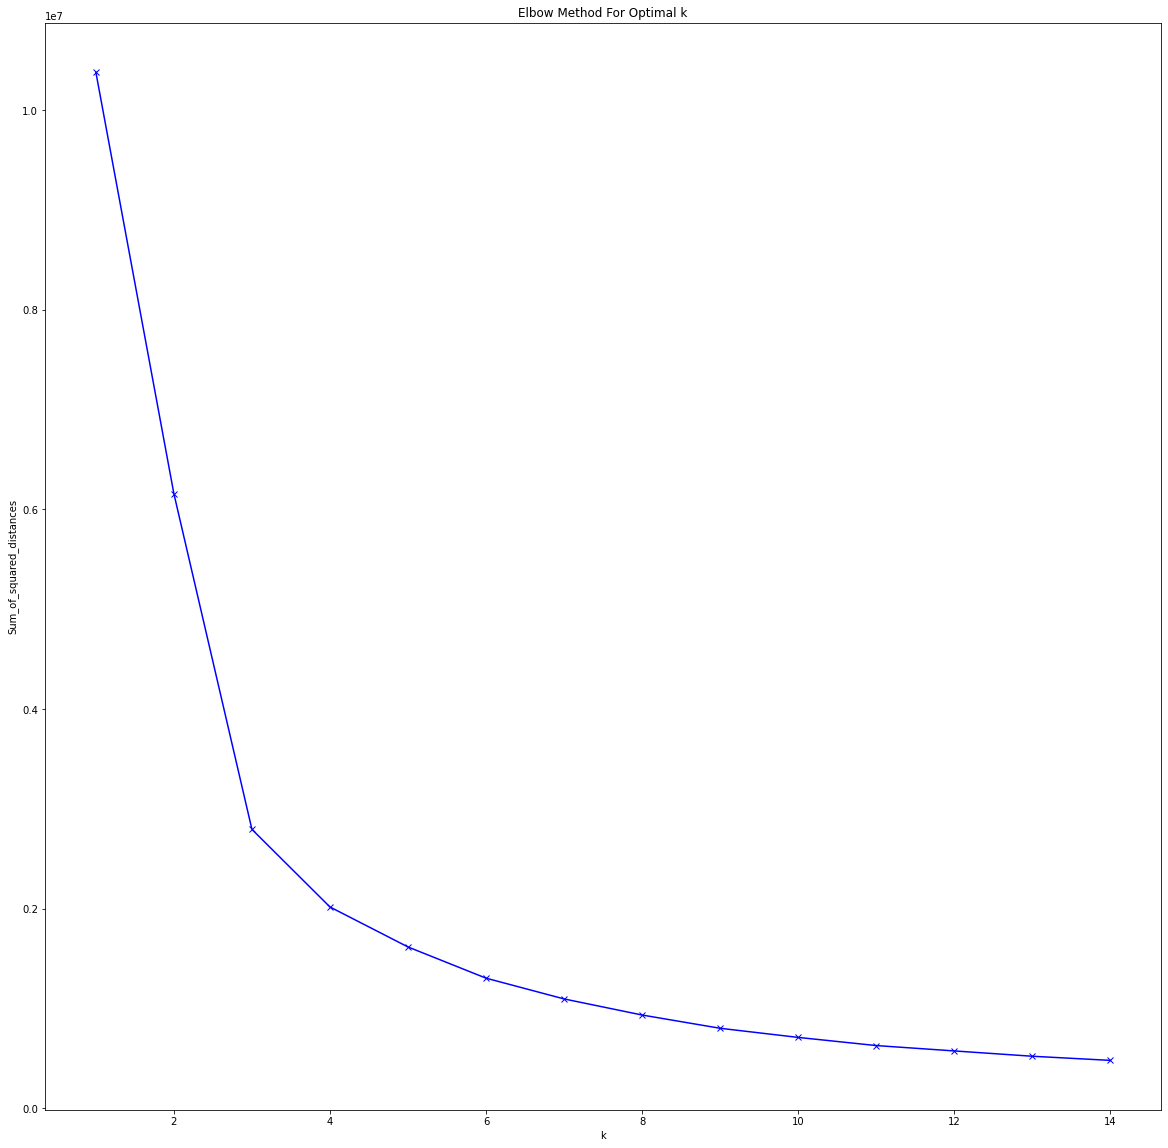

In [280]:
#find optimal number of clusters
from sklearn.preprocessing import MinMaxScaler

data = np.array(dff_new.values.tolist())
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

###### From the result of the plot we can see that the most optimal number of clusters is k = 4

### Gap statistics

0it [00:00, ?it/s]C:\Temp\ipykernel_10144\2076214135.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
1it [00:04,  4.29s/it]C:\Temp\ipykernel_10144\2076214135.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
2it [00:23, 13.04s/it]C:\Temp\ipykernel_10144\2076214135.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
3it [00:52, 20.34s/it]C:\Temp\ipykernel_10144\2076214135.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

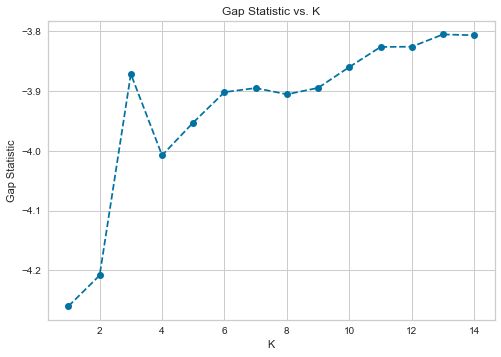

In [400]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in tqdm(enumerate(range(1, maxClusters))):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(data, nrefs=5, maxClusters=15)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

Let's take k=4

#### Mapreduce functions

In [273]:
from collections import defaultdict
import numpy as np
def mapper(myu, data):
    def my_func(x_i):
        delta= myu - x_i
        delta = list(map(np.linalg.norm, delta))
        min_len = min(delta)
        index = delta.index(min_len)
        return (index, x_i)
    return list(map(my_func, data))
def combiner(mapped):
    centroids = defaultdict(set)
    mapped = sorted(mapped, key=lambda x: x[0])
    for i in mapped:
        centroids[i[0]].add(tuple(i[1]))
    return centroids
def reducer(mapped, k):
    #shuffle
    cluster = combiner(mapped)
    myu_new = np.zeros((k,2))
    for  i in cluster:
        set_i = cluster[i]
        result = [sum(tup) for tup in zip(*set_i)]
        myu_new[i] = np.array(result) *(1/len(cluster[i]))
    return myu_new, cluster
    
        

#### KMeans algorithm with mapreduce

In [ ]:
from collections import defaultdict
import random
data = dff_new.values.tolist()
import numpy
def k_means(data, k, epsilon):
    #choose random from existing points
    myu_new = random.choices(data, k=k)
    myu_new = np.array(myu_new)
    #check number of iterations
    t = 0
    myu_old = np.zeros((k,2))
    a = myu_old-myu_new
    a = list(map(np.linalg.norm, a))
    cluster = defaultdict(set)
    while sum(a) > epsilon:
        t += 1
        mapped = mapper(myu_new, data)
        #centroid update
        myu_old = myu_new.copy()
        myu_new,cluster = reducer(mapped,k)
        a = myu_old-myu_new
        a = list(map(np.linalg.norm, a))
    return cluster,myu_new
k, centroids = k_means(data,4, 0.1)

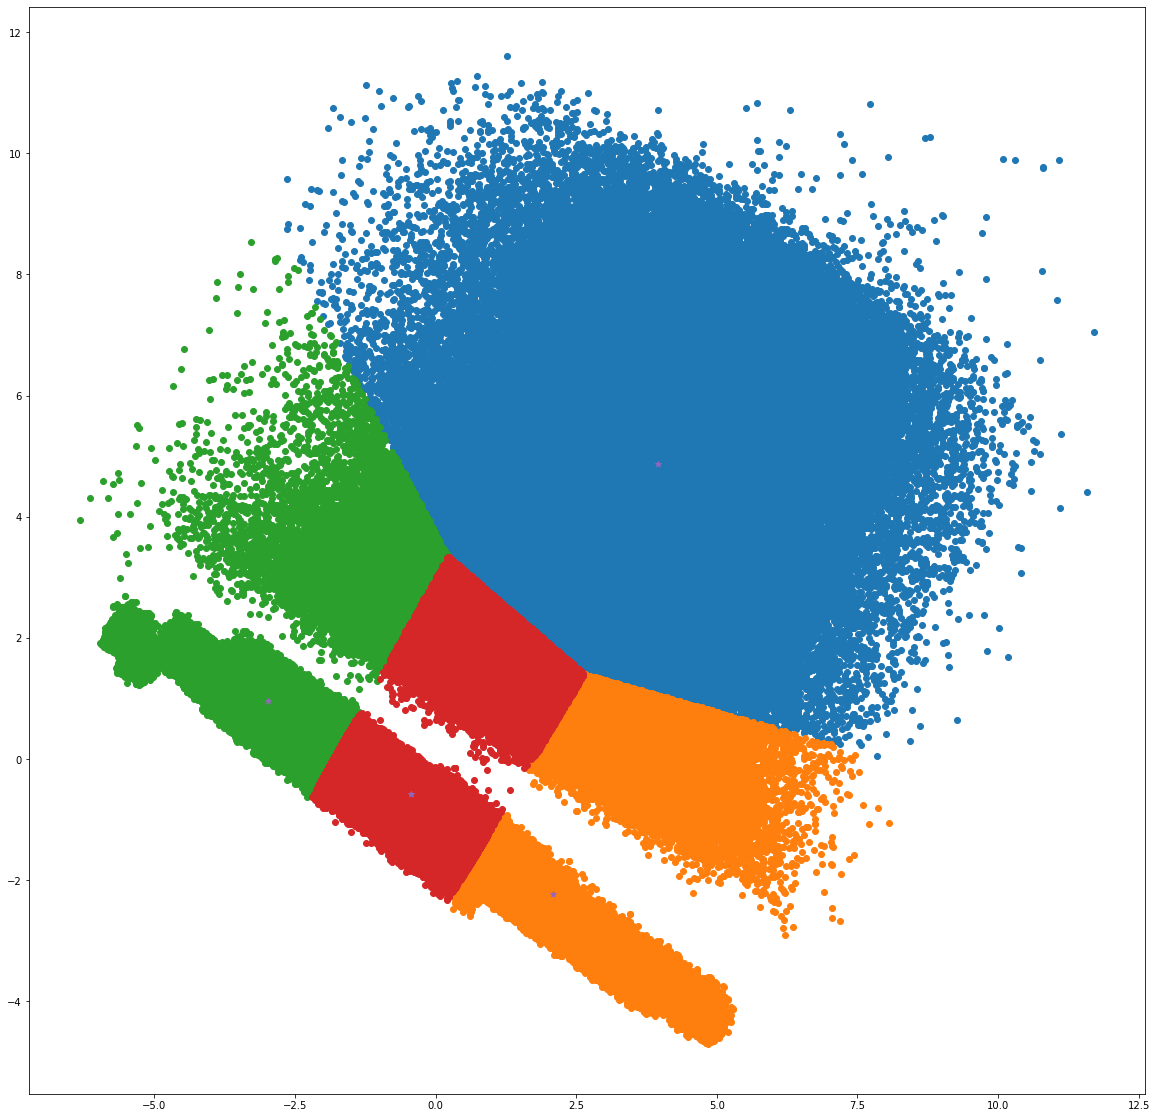

In [275]:
import matplotlib.pyplot as plt
keys_k = k.keys()
for i in keys_k:
    plt.scatter(*list(zip(*k[i])))
plt.scatter(*list(zip(*centroids)), marker= '*')
#plt.xlim([-20000, 20000])
#plt.ylim([-20000, 20000])
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

#### Using kmeans++ and comaring the results

In [276]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4 ,init="k-means++")
kmeans = kmeans.fit(data)

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

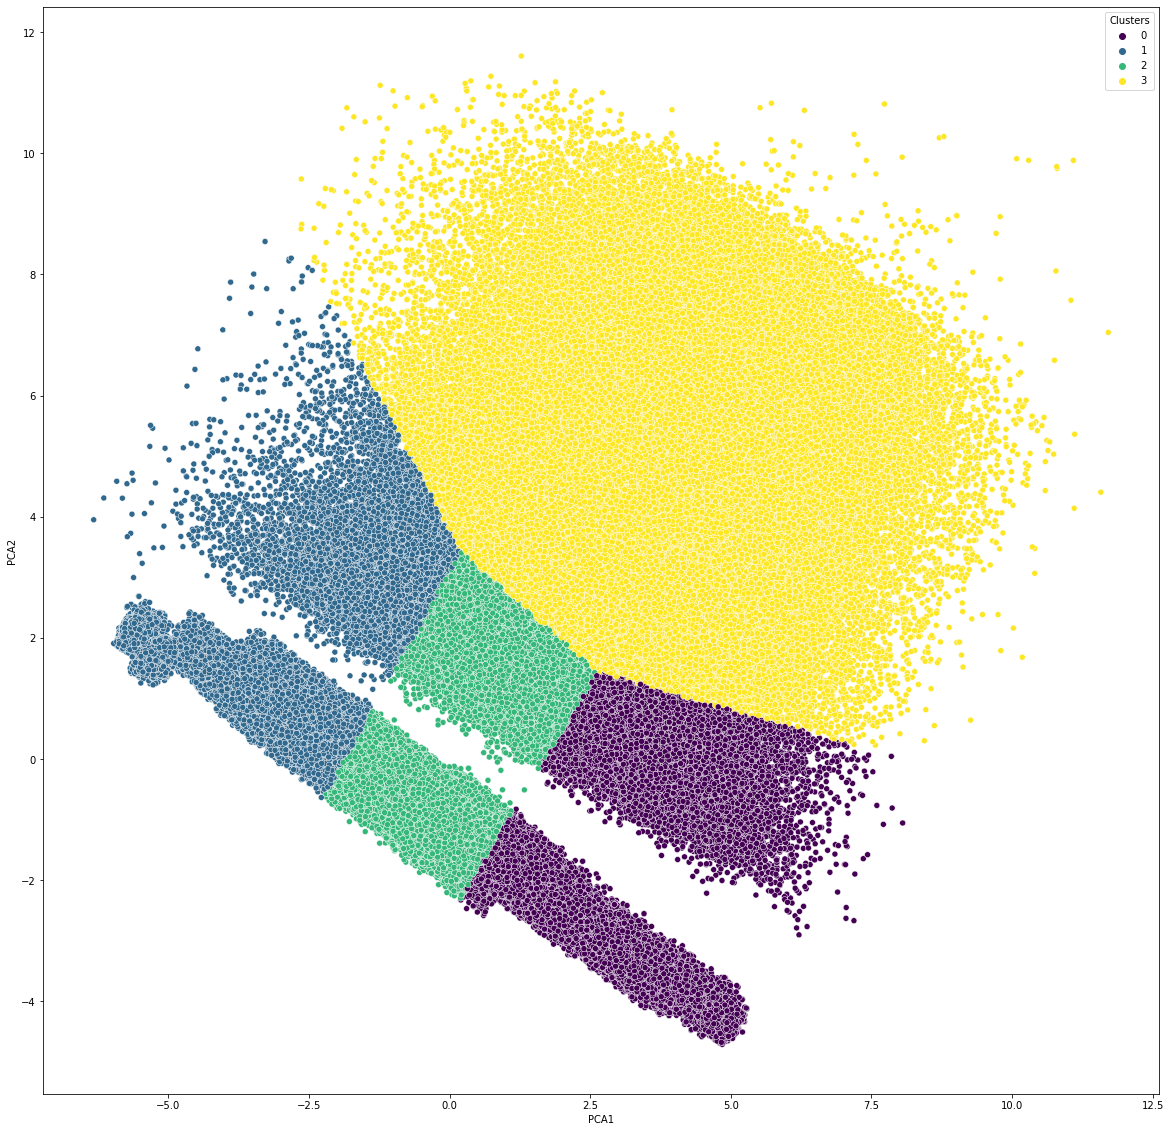

In [277]:
import seaborn as sns
dff_new['Clusters'] = kmeans.labels_

sns.scatterplot(x="PCA1", y="PCA2",hue = 'Clusters',  data=dff_new,palette='viridis')


## 2.4 Analysing your results

In [ ]:
#most_common_gender
n_females = 0
n_males = 0
small_balance = 0
big_balance = 0
gender_set = {}
average_balance = {}
for i in k:
    for j in tqdm(k[i]):
        index = data.index(list(j))
        sub_df = dff.loc[[index]]
        gender = sub_df.MostCommonGender.iloc[0]
        balance = sub_df.AverageBalance.iloc[0]
        #if male
        if gender == 1: 
            n_males += 1
        #if females
        elif gender == 0:
            n_females +=1
        #balance comparison
        if balance > 10000:
            big_balance +=1
        elif balance <=10000:
            small_balance += 1
    #percentage of gender
    gender_set[i] = [(n_females/(n_females + n_males))*100, (n_males/(n_females + n_males))*100]
    n_females = 0
    n_males = 0
    
    
    average_balance[i] = [(small_balance/(small_balance + big_balance))*100, (big_balance/(small_balance + big_balance))*100]
    small_balance = 0
    big_balance = 0

            
        

In [311]:
df_gender = pd.DataFrame(columns = ['%F', '%M'])
for i in gender_set:
    df_gender.loc[i] = gender_set[i]
df_gender.index.name = 'Cluster'

In [312]:
df_gender

,%F,%M
Cluster,,
0,22.470942,77.529058
1,42.075053,57.924947
2,32.700118,67.299882
3,29.428842,70.571158


In [314]:
df_balance = pd.DataFrame(columns= ['ave_balance <= 1000 USD', 'ave_balance > 1000 USD'])
for i in average_balance:
    df_balance.loc[i] = average_balance[i]
df_balance.index.name = 'Cluster'

In [338]:
df_balance

,ave_balance <= 10000 USD,ave_balance > 10000 USD
Cluster,,
0,22.134976,77.865024
1,0.507400,99.492600
2,0.000000,100.000000
3,0.428503,99.571497


# CommandLine 

The command line is a usefull tool to get informations quickly from a dataset.

Here we will answer some simple questions using the command line.

#### Which location has the maximum number of purchases been made?

To find the answer to this question we have to count how many times each location appear in the dataset and then sort the result. So after creating a list c that will have the column 5 (the locations) of the dataset as indexes and add one to the element corresponding to the location each time we entounter it.

In [128]:
%%bash
awk -F "," '{ c[$5]++;}; END{for(x in c) print c[x], x;}' bank_transactions.csv | sort -r -g | head

103595 MUMBAI
84928 NEW DELHI
81555 BANGALORE
73818 GURGAON
71019 DELHI
32784 NOIDA
30009 CHENNAI
25851 PUNE
23049 HYDERABAD
21505 THANE


#### In the dataset provided, did females spend more than males, or vice versa?

To answer this question we thought of looking for both the absolute value of how much they spend and the average. In both cases, similarly to the previous question we create a list and each time we encounter a costumer we add, to the element corresponding to their gender, how much they spent. This will give us the absolute value.

In [11]:
%%bash
awk -F ',' '{spent[$4]+=$9;}; END{for(x in spent) print spent[x], x;}' bank_transactions.csv |sort -r -g | grep 'F\|M'

1232800068 M
485236122 F


To get the average we create, together with the previous list, a list that count how many times the genders appear. To finish we just divide the two lists.

In [12]:
%%bash
awk -F ',' '{spent[$4]+=$9; count[$4]++;}; END{for(x in spent) print spent[x]/count[x], x;}' bank_transactions.csv |sort -r -g | grep 'F\|M' 

1721,09 F
1610,39 M


#### Report the customer with the highest average transaction amount in the dataset.

Just like the second version but we count how much each costumer spend summing over the 'CustomerID' and divide by how many times each 'CustomerID' appears.

In [149]:
%%bash
awk -F ',' '{spent[$2]+=$9; count[$2]++;}; END{for(x in spent) print spent[x]/count[x], x;}' bank_transactions.csv |sort -r -g | head 

1560034 C7319271
1380002 C6677159
991132 C4141768
720001 C1830891
600008 C6549785
600003 C5036642
569500 C4328064
561001 C1425138
557000 C5833636
543699 C7549492


# Algorithms

In [ ]:
from collections import Counter

In [401]:
n,m,g = eval(input())
a = list(map(int,input().split()))

4,5,1
1 2 1 2 3


In [402]:
def is_enough(a, g):
    count_a = Counter(a)
    S = set()
    for i in a:
        S.add(i)
        count_a[i] -=1
        if count_a[i] == 0:
            S.remove(i)
        if len(S) > g:
            return "NO"
    return 'YES'

In [403]:
print(is_enough(a,g))

NO
